In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from numpy.random import Generator, PCG64

import tqdm
import inspect
import warnings
warnings.filterwarnings('ignore')

In [2]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

##### Config

In [3]:
pd.set_option("display.max_rows", None)

# Functions for adjusting distributions

In [4]:
def select_distribution(familia='realall', verbose=True):
    """
    This function selects a subset of the available distributions
    in scipy.stats
    
    Parameters
    ----------
    family : {'realall', 'realline', 'realplus', 'real0to1', 'discrete'}
        realall: distributions of `realline` + `realplus` family
        realline: continuous distributions in the domain (-inf, +inf)
        realplus: continuous distributions in domain [0, +inf)
        real0to1: continuous distributions in the domain [0, 1].
        discrete: discrete distributions
        
    verbose : bool
        If information of the selected distributions is displayed
        (the default `True`).
        
    Returns
    -------
    distributions: list
        list with the selected distributions (objects).
        
    Raises
    ------
    Exception
        If `family` is different from `realall`, `realline`, `realplus`, `real0to1`,
        or 'discrete'.
        
    Notes
    -----
        The levy_stable and vonmises distributions have been excluded for the time being.

    """
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    # if verbose:
    #     print("---------------------------------------------------")
    #     print("       Distribuciones seleccionadas                ")
    #     print("---------------------------------------------------")
    #     with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    #         print(info_distribuciones)
    return seleccion

In [5]:
def comparison_distribution(x, familia='realall', ordenar='aic', verbose=True):
    """
    This function selects and adjusts a subset of the distributions available in scipy.stats. 
    available in scipy.stats. For each distribution it calculates the values of
    Log Likelihood, AIC and BIC.
    
    Parameters
    ----------
    x : array_like
        data with which to fit the distribution.
        
    family : {'realall', 'realline', 'realplus', 'real0to1', 'discrete'}
        realall: distributions of the `realline` + `realplus` family.
        realline: continuous distributions in the domain (-inf, +inf)
        realplus: continuous distributions in domain [0, +inf)
        real0to1: continuous distributions in the domain [0, 1].
        discrete: discrete distributions
    
    ordering : {'aic', 'bic'}
        sorting criterion from best to worst fit.
    
    verbose : bool
        If information from the selected distributions is shown
        (the default `True`).
        
    Returns
    -------
    results: data.frame
        distribution: name of the distribution.
        log_likelihood: log likelihood of the fit.
        aic: AIC metric.
        bic: BIC metric.
        n_parameters: number of parameters of the distribution of the distribution.
        parameters: parameters of the after fit
        
    Raises
    ------
    Exception
        If `family` is different from 'realall', 'realline', 'realplus', 'real0to1',
        or 'discrete'.
    """
    
    distribuciones = select_distribution(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        if i>=100:
            continue
        
        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

In [6]:
def plot_distribution(x, nombre_distribucion, ax=None):
    """
    This function overlays the density curve of a distribution with the histogram of the data.
    histogram of the data.
    
    Parameters
    ----------
    x : array_like
        data with which to fit the distribution.
        
    distribution_name : str
        name of one of the distributions available in `scipy.stats`.
        
    Returns
    -------
    results: matplotlib.ax
        graph created
        
    """

    distribucion = getattr(stats, nombre_distribucion)
    parametros = distribucion.fit(data=x)
    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))
    log_likelihood = distribucion.logpdf(x, *parametros).sum()
    
    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajustment Distribution')
    ax.set_xlabel('Daily Demand')
    ax.set_ylabel('Probability Density')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    
    return ax

In [7]:
def plot_multiple_distributions(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajustment Distribution')
    ax.set_xlabel('Daily Demand')
    ax.set_ylabel('Probability Density')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    
    ax.legend();
    
    return ax

# Objetive
The objective of this playground is to determine the distributions to be used to sample average daily demand in different months according to the type of layer.

# Data

### Load

In [8]:
## Consider output of Compute-Layer-Process
raw = pd.read_csv("../../data/output_layer_process.csv")

In [9]:
n_rows = len(raw.index)
logger.info(f'Quantity of rows input {n_rows}')

INFO:__main__:Quantity of rows input 71774


# Overview

In [10]:
## Quantity of customers per year-month-layer
pd.pivot_table(data=raw, index=["year","month"], columns=["layer"], values="cod_customer", aggfunc="count")

layer            0     1      2
year month                     
2020 1      1421.0   9.0   42.0
     2      1253.0  14.0   46.0
     3      1057.0   4.0   29.0
     4       962.0   6.0   18.0
     5      1138.0   6.0   31.0
     6      1284.0   9.0   48.0
     7      1293.0  14.0   49.0
     8      1189.0   5.0   38.0
     9      1525.0   5.0   56.0
     10     1787.0   7.0   73.0
     11     1685.0  17.0   75.0
     12     2030.0  17.0   93.0
2021 1      1391.0   7.0   82.0
     2       385.0   NaN    9.0
     3      1734.0   3.0   68.0
     4      1683.0   5.0   69.0
     5      1530.0  13.0   64.0
     6      1473.0  11.0   46.0
     7      1732.0  12.0   75.0
     8      1795.0  13.0   71.0
     9      2055.0  13.0   87.0
     10     2339.0  20.0   91.0
     11     1896.0  15.0   97.0
     12     2513.0  26.0  112.0
2022 1      1760.0  17.0   83.0
     2      2495.0  18.0   99.0
     3      2594.0  13.0  107.0
     4      2459.0  13.0   86.0
     5      2214.0  20.0   86.0
     6      2831.0  15.0  127.0
     7      2558.0  24.0   93.0
     8      2534.0  22.0   92.0
     9      2758.0  22.0  128.0
     10     2998.0  26.0  134.0
     11     2853.0  29.0  122.0
     12     3293.0  37.0  144.0

## Distribution of Avg Daily Demand

### 1) Layer Low-Demand

In [11]:
raw_low = raw[raw.layer==0].reset_index(drop=1)
logger.info(f"Quantity of rows is {len(raw_low.index)}")

INFO:__main__:Quantity of rows is 68497


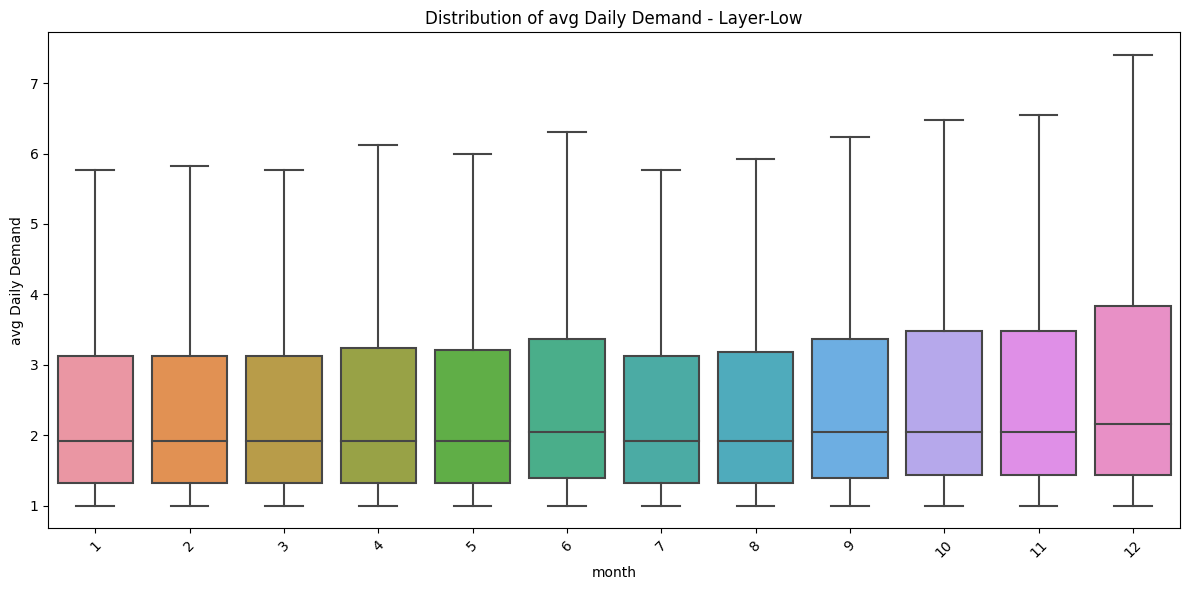

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='demand', data=raw_low, showfliers=False)
plt.xticks(rotation=45)
plt.ylabel('avg Daily Demand')
plt.title('Distribution of avg Daily Demand - Layer-Low')
plt.tight_layout()
plt.show()

#### Distribution adjustment

In [13]:
data_to_adjustment = raw_low.loc[raw_low.month == 1, 'demand']

In [14]:
resultados_low = comparison_distribution(
                x=data_to_adjustment.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_low

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,dweibull,-5873.628403,11753.256806,11772.539924,3,"{'c': 0.6700198833706152, 'loc': 1.43999999999..."
1,dgamma,-6712.563079,13431.126157,13450.409275,3,"{'a': 0.6854457034916532, 'loc': 1.55999999999..."
2,genhyperbolic,-6861.242453,13732.484906,13764.623436,5,"{'p': 0.395570869330484, 'a': 1.46823323328432..."
3,johnsonsu,-6904.787515,13817.575030,13843.285854,4,"{'a': -4.807745279338757, 'b': 0.7733888841112..."
4,norminvgauss,-6914.471875,13836.943749,13862.654573,4,"{'a': 54.71568666181014, 'b': 54.7140229939948..."
5,skewcauchy,-7007.876036,14021.752071,14041.035189,3,"{'a': 0.9552602199637652, 'loc': 1.08057176293..."
6,pearson3,-7079.398686,14164.797372,14184.080490,3,"{'skew': 2.2343172000892997, 'loc': 2.73210715..."
7,genextreme,-7079.544204,14165.088407,14184.371525,3,"{'c': -0.8480103523335814, 'loc': 1.5357010224..."
8,laplace_asymmetric,-7162.719010,14331.438020,14350.721138,3,"{'kappa': 0.140080332324638, 'loc': 1.07999990..."
9,exponnorm,-7169.326640,14344.653280,14363.936398,3,"{'K': 88.97694227641229, 'loc': 1.027637069218..."


------ MONTH 1 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -4.807745279338757, 'b': 0.773388884111248, 'loc': 0.9927181072134932, 'scale': 0.003381593167730684}
Log likelihood: -6904.787514958782
AIC:            13817.575029917563
BIC:            13843.285854017222


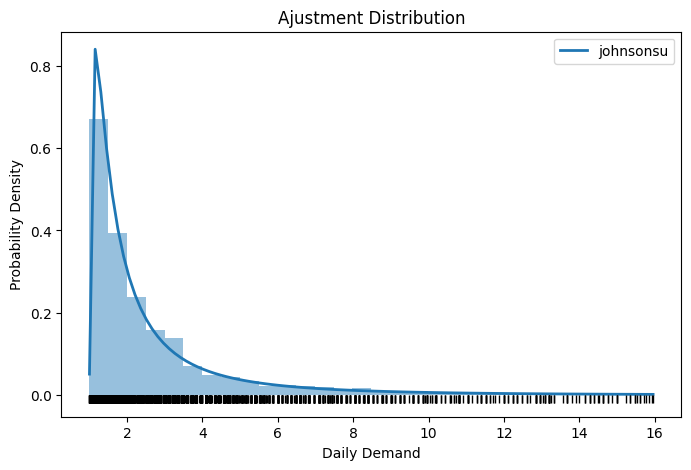

------ MONTH 2 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -4.816430790641132, 'b': 0.7797548561312492, 'loc': 0.99437811936145, 'scale': 0.0036337374577629688}
Log likelihood: -6340.446191583208
AIC:            12688.892383166416
BIC:            12714.199418424463


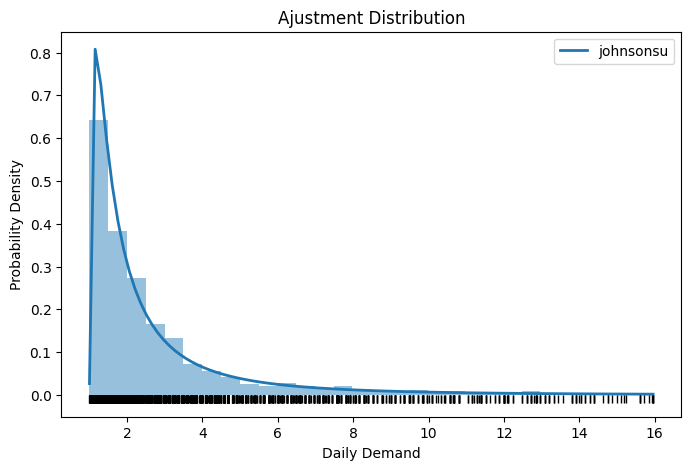

------ MONTH 3 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -4.947549766877758, 'b': 0.7777076520263277, 'loc': 0.9911220946881644, 'scale': 0.003033144998833001}
Log likelihood: -8304.698300998081
AIC:            16617.396601996163
BIC:            16643.762092354526


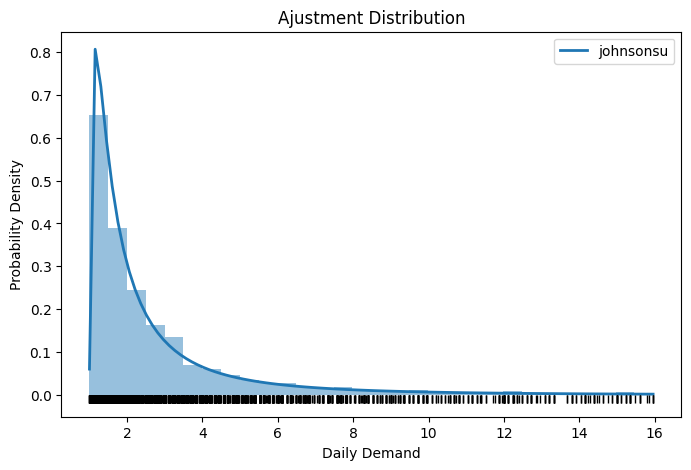

------ MONTH 4 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -4.919360522179474, 'b': 0.7740023485024676, 'loc': 0.9909736001278993, 'scale': 0.0030391021166006225}
Log likelihood: -7870.582997251091
AIC:            15749.165994502182
BIC:            15775.31711380228


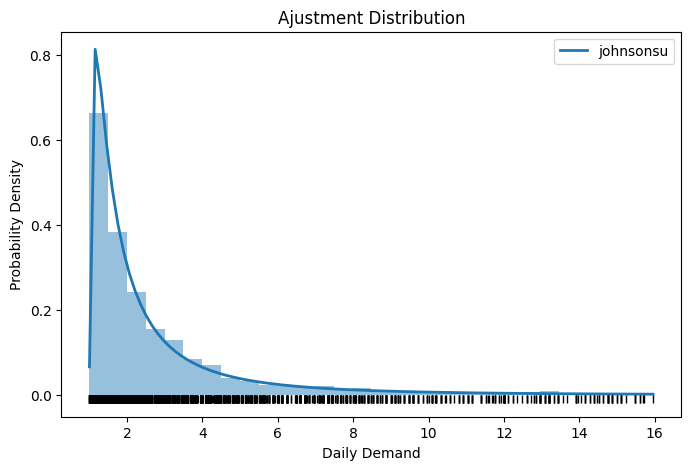

------ MONTH 5 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -4.126886682947598, 'b': 0.7850403991916988, 'loc': 0.9882063380291453, 'scale': 0.00926217123085547}
Log likelihood: -7533.315778718504
AIC:            15074.631557437007
BIC:            15100.60479844082


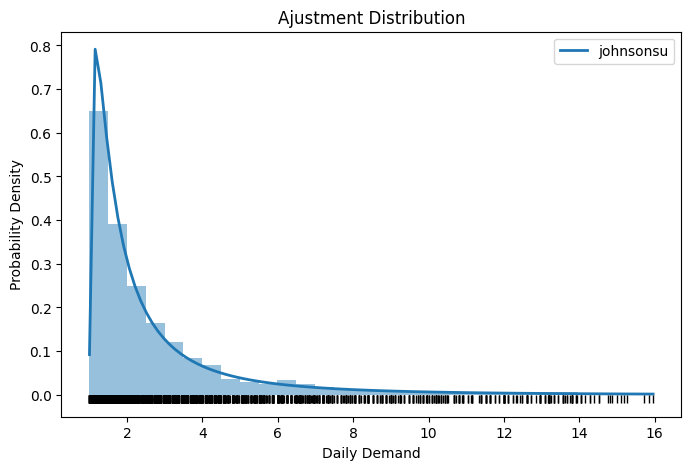

------ MONTH 6 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -4.890860326168944, 'b': 0.7825434846293198, 'loc': 0.9848989893866555, 'scale': 0.0037570725613611314}
Log likelihood: -9154.27986088396
AIC:            18316.55972176792
BIC:            18343.073228649428


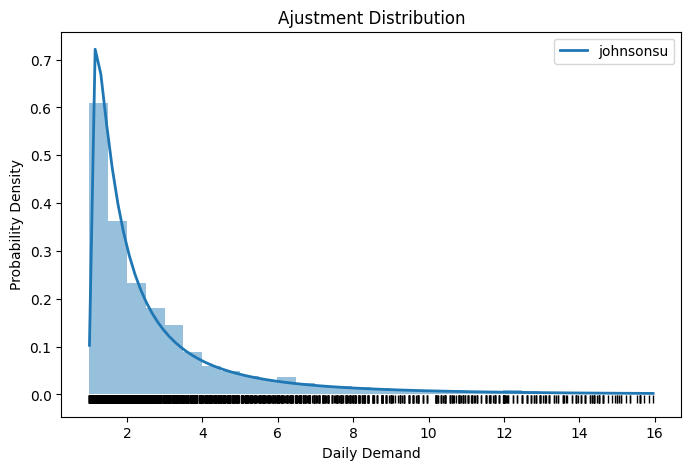

------ MONTH 7 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.081622394812156, 'b': 0.787335957455368, 'loc': 0.9840140799725035, 'scale': 0.002843352997077343}
Log likelihood: -8685.416386516652
AIC:            17378.832773033304
BIC:            17405.342699214547


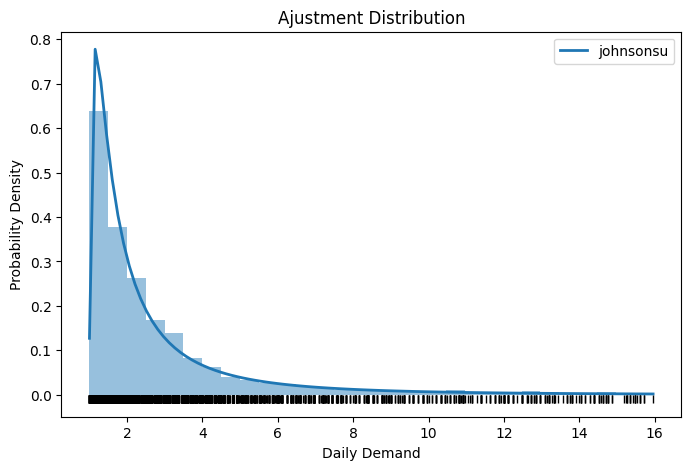

------ MONTH 8 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.052541315493812, 'b': 0.7838769849244744, 'loc': 0.98280708415095, 'scale': 0.002846890206620361}
Log likelihood: -8576.970961182687
AIC:            17161.941922365375
BIC:            17188.405005384484


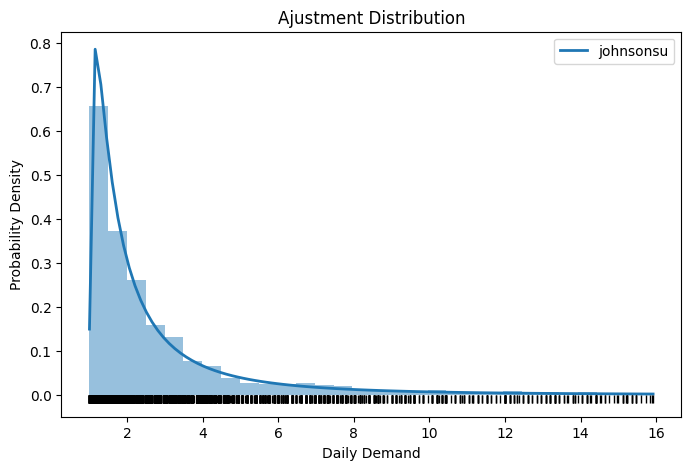

------ MONTH 9 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.057775172178726, 'b': 0.7875992129263074, 'loc': 0.9790647331206848, 'scale': 0.0031448292395374004}
Log likelihood: -10298.855746815481
AIC:            20605.711493630963
BIC:            20632.728767791967


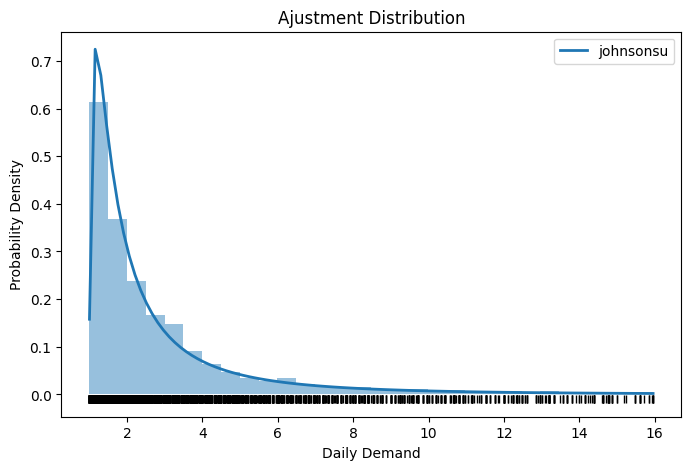

------ MONTH 10 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.081698973619364, 'b': 0.7922277018044817, 'loc': 0.978667105964234, 'scale': 0.003268813170139573}
Log likelihood: -11754.758793344234
AIC:            23517.517586688467
BIC:            23545.002485266104


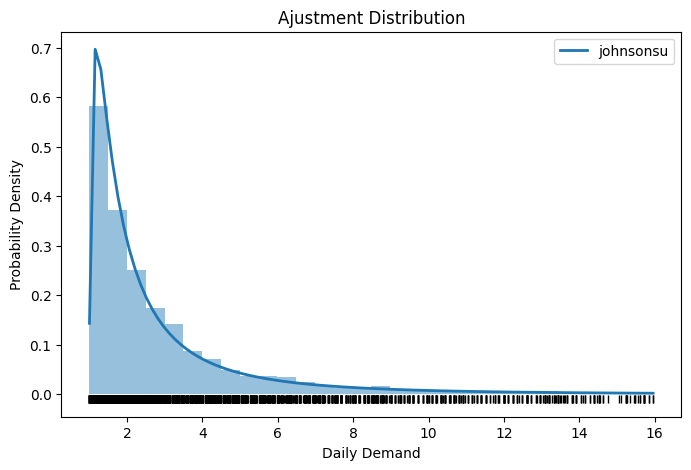

------ MONTH 11 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.217159288145458, 'b': 0.7902864986526663, 'loc': 0.978368471683833, 'scale': 0.0027478361392463766}
Log likelihood: -10718.220211846748
AIC:            21444.440423693497
BIC:            21471.51783052469


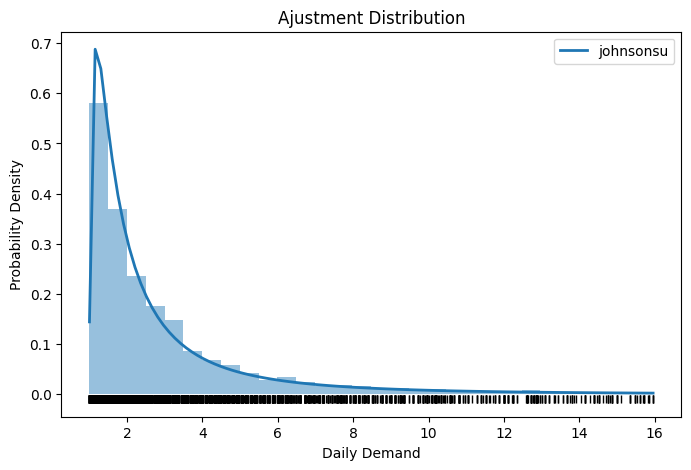

------ MONTH 12 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.253145845420855, 'b': 0.790563600810962, 'loc': 0.9799406870153695, 'scale': 0.002936272303643489}
Log likelihood: -13910.560473916801
AIC:            27829.120947833602
BIC:            27856.98688294986


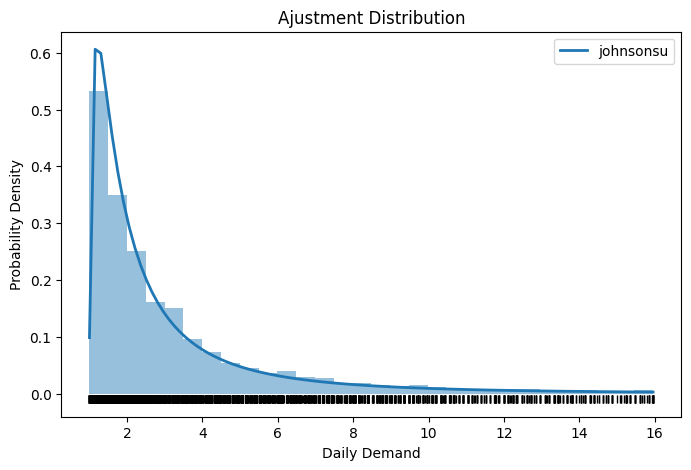

In [15]:
for month in range(1,13):
    data = raw_low.loc[raw_low.month == month, 'demand']
    print(f"------ MONTH {month} -------")
    fig, ax = plt.subplots(figsize=(8,5))
    plot_distribution(
        x=data.to_numpy(),
        nombre_distribucion=resultados_low['distribucion'][3],
        ax=ax
    )
    plt.show()

#### Sampling Layer Low and Month 12

INFO:__main__:(-4.890860326168944, 0.7825434846293198, 0.9848989893866555, 0.0037570725613611314)


[ 1.14589119  1.85842792  1.4815376  ... 10.84278788  1.39305721
  1.24329674]


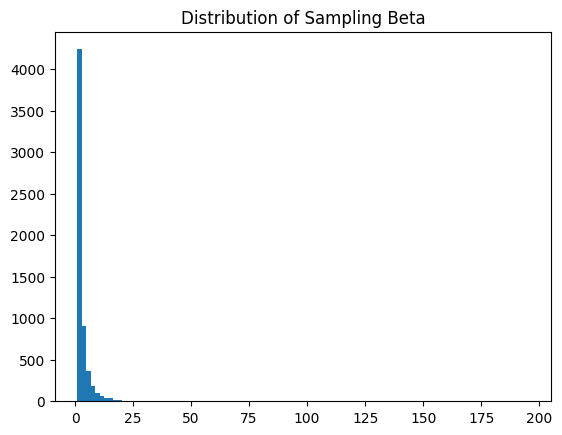

INFO:__main__:Rows 5588


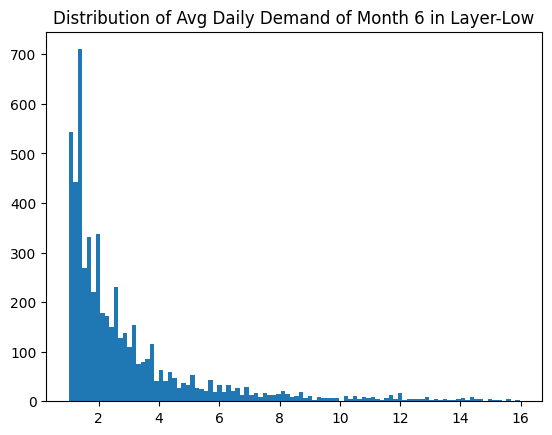

In [16]:
MONTH = 6
## Distribution Selected
distribution = stats.johnsonsu

# fitting
parametros   = distribution.fit(raw_low.loc[raw_low.month == MONTH, 'demand'].to_numpy())
logger.info(parametros)

# plot with sampling 10000 records
plt.hist(distribution.rvs(*parametros, size=6000), bins = 100)
print(distribution.rvs(*parametros, size=6000))
#plt.xlim(0, 17)
plt.title("Distribution of Sampling Beta")
plt.show()


logger.info(f"Rows {len(raw_low.loc[raw_low.month == MONTH, 'demand'])}")
plt.hist(raw_low.loc[raw_low.month == MONTH, 'demand'], bins=100)
plt.title(f"Distribution of Avg Daily Demand of Month {MONTH} in Layer-Low")
plt.show()

### 2) Layer Medium-Demand

In [17]:
raw_medium = raw[raw.layer==2].reset_index(drop=1)
logger.info(f"Quantity of rows is {len(raw_medium.index)}")

INFO:__main__:Quantity of rows is 2770


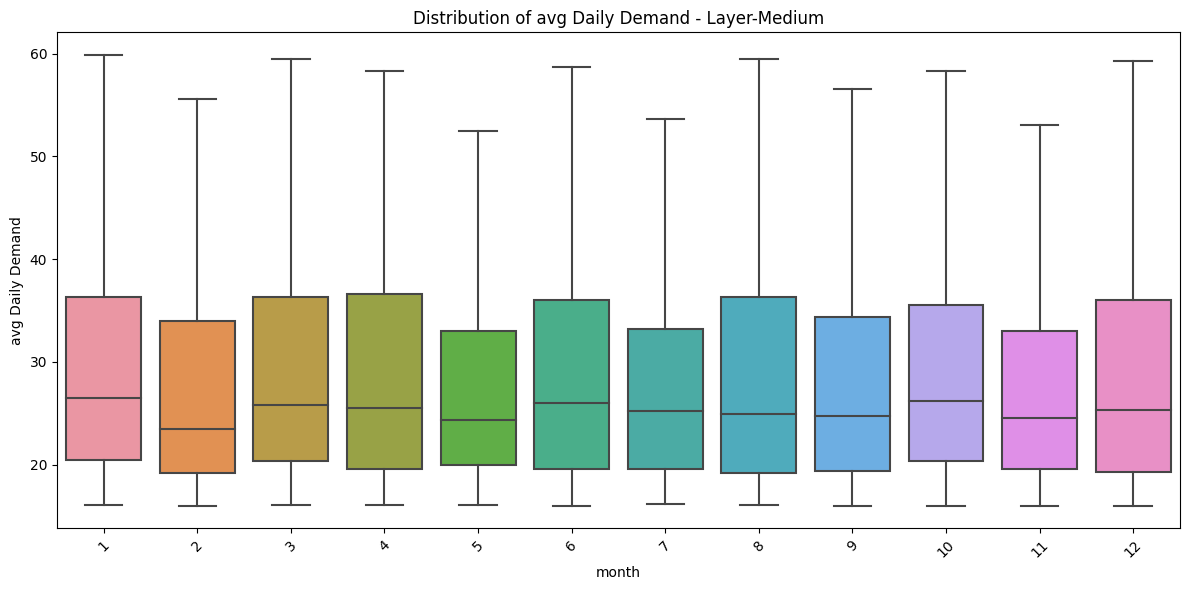

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='demand', data=raw_medium, showfliers=False)
plt.xticks(rotation=45)
plt.ylabel('avg Daily Demand')
plt.title('Distribution of avg Daily Demand - Layer-Medium')
plt.tight_layout()
plt.show()

#### Distribution adjustment

In [19]:
data_to_adjustment = raw_medium.loc[raw_medium.month == 1, 'demand']

In [20]:
resultados_medium = comparison_distribution(
                x=data_to_adjustment.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_medium

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,kappa4,-732.108403,1472.216805,1485.547681,4,"{'h': 1.1979250180308696, 'k': 0.5439461758470..."
1,loguniform,-738.332890,1484.665781,1497.996656,4,"{'a': 5.349200188276244, 'b': 49.1576399494652..."
2,reciprocal,-738.332890,1484.665781,1497.996656,4,"{'a': 5.349200188276244, 'b': 49.1576399494652..."
3,truncweibull_min,-738.310364,1486.620729,1503.284322,5,"{'c': 0.7491142546992648, 'a': 0.0014699712056..."
4,pearson3,-749.600641,1505.201282,1515.199438,3,"{'skew': 2.02229847889947, 'loc': 29.965685030..."
5,skewnorm,-749.707736,1505.415471,1515.413628,3,"{'a': 36441329.52211213, 'loc': 16.07999754487..."
6,laplace_asymmetric,-750.815931,1507.631863,1517.630019,3,"{'kappa': 6.847005760772205e-05, 'loc': 16.079..."
7,exponnorm,-751.156045,1508.312089,1518.310246,3,"{'K': 1444.2787984836405, 'loc': 16.0610949057..."
8,genhyperbolic,-750.350824,1510.701648,1527.365242,5,"{'p': 0.805392947649159, 'a': 1.34148572431820..."
9,norminvgauss,-761.925874,1531.851747,1545.182622,4,"{'a': 101.8005384097379, 'b': 101.789082205726..."


------ MONTH 1 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 5.349200188276244, 'b': 49.15763994946528, 'loc': 10.730799811658551, 'scale': 1}
Log likelihood: -738.3328903398658
AIC:            1484.6657806797316
BIC:            1497.996655852793


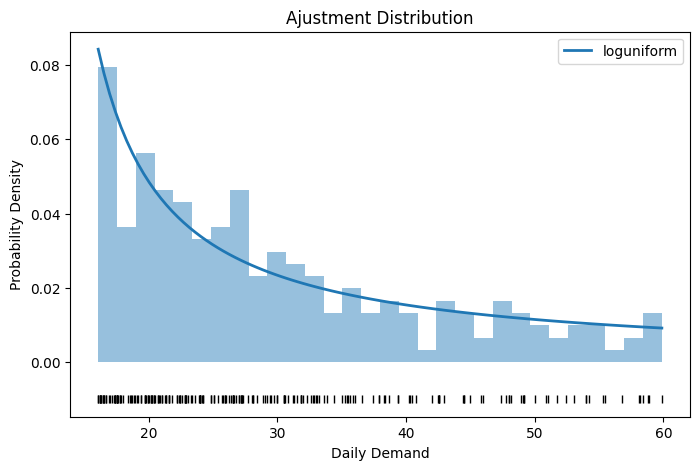

------ MONTH 2 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 3.3195867004361244, 'b': 46.01040345969244, 'loc': 12.669596554265059, 'scale': 1}
Log likelihood: -529.0851556065332
AIC:            1066.1703112130665
BIC:            1078.318121622721


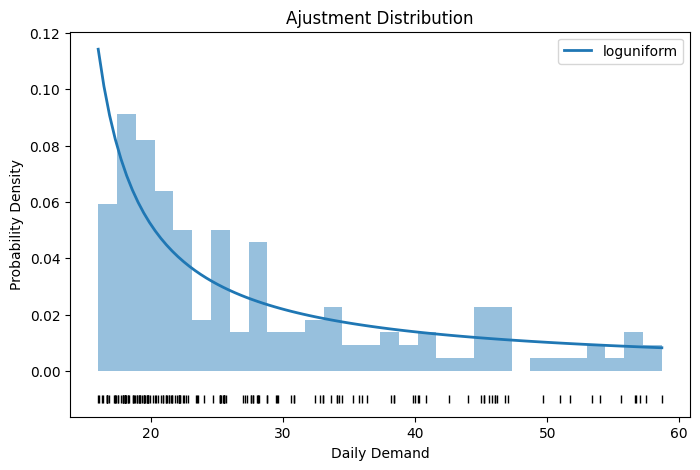

------ MONTH 3 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 5.156170652142544, 'b': 48.66810506511109, 'loc': 10.85189493516041, 'scale': 1}
Log likelihood: -722.9643575216455
AIC:            1453.928715043291
BIC:            1467.201195018668


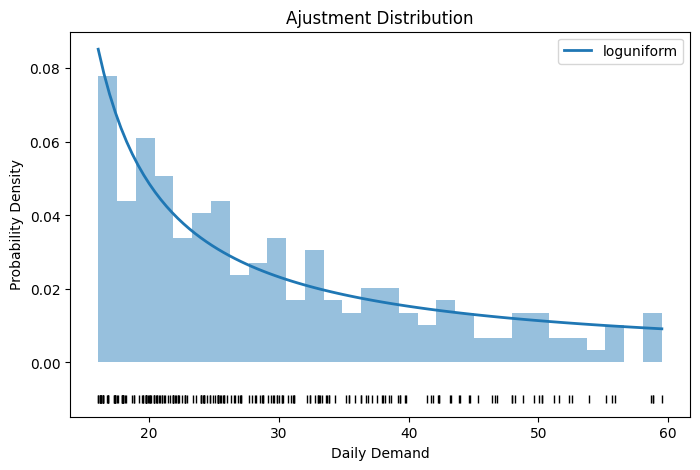

------ MONTH 4 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 3.5432129139862547, 'b': 48.0764799598432, 'loc': 12.536787085955329, 'scale': 1}
Log likelihood: -606.6729586220259
AIC:            1221.3459172440519
BIC:            1233.959083622043


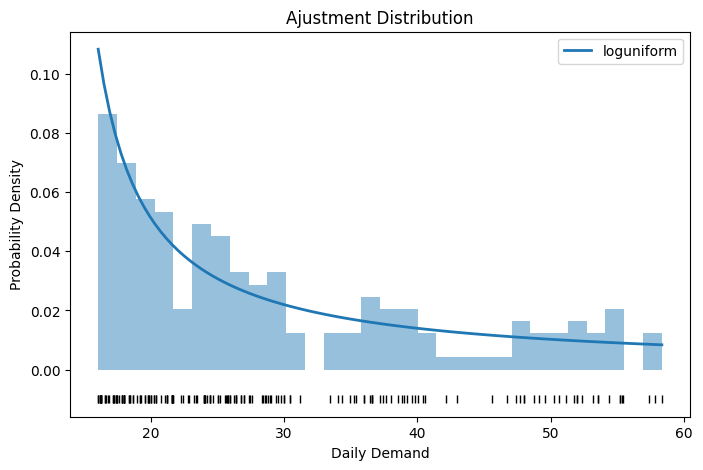

------ MONTH 5 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 19.02820684726579, 'b': 61.448216015560604, 'loc': -2.9482128902077394, 'scale': 1}
Log likelihood: -642.0865411759696
AIC:            1292.1730823519392
BIC:            1304.9670704770026


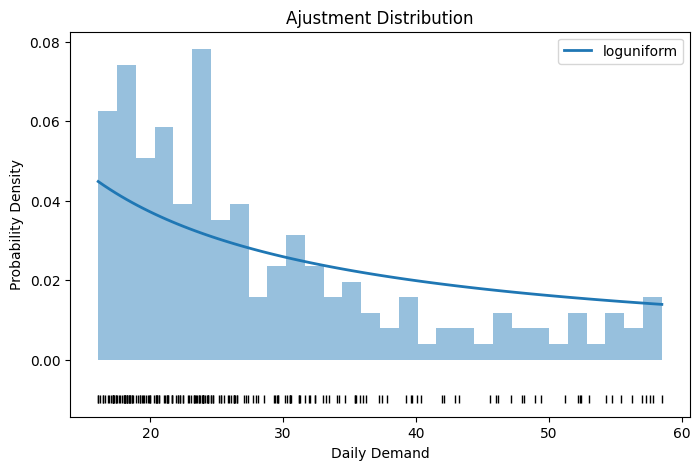

------ MONTH 6 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 19.65530068277928, 'b': 62.335305881143896, 'loc': -3.655302014300439, 'scale': 1}
Log likelihood: -791.2213764015016
AIC:            1590.4427528030033
BIC:            1604.0354036090744


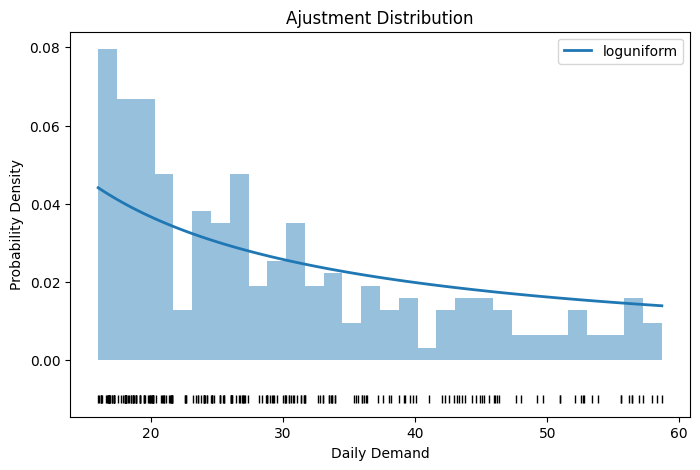

------ MONTH 7 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 3.609949013445087, 'b': 45.37148716322504, 'loc': 12.468512837595743, 'scale': 1}
Log likelihood: -747.5110808673427
AIC:            1503.0221617346854
BIC:            1516.5417511488472


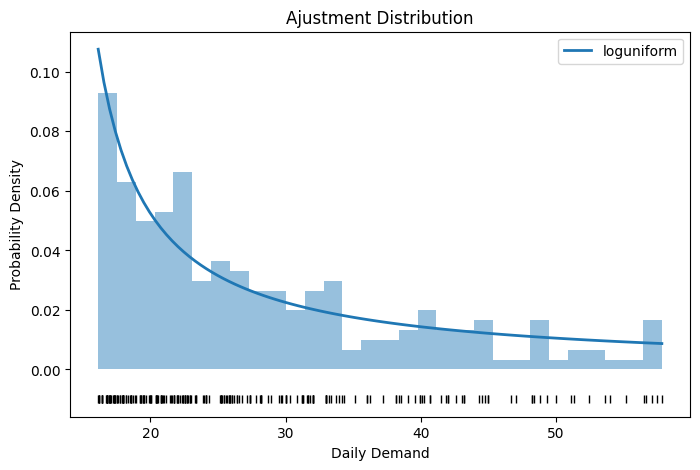

------ MONTH 8 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 3.203894328579686, 'b': 46.65909012953756, 'loc': 12.87312237057067, 'scale': 1}
Log likelihood: -699.6222235003181
AIC:            1407.2444470006362
BIC:            1420.4576666328726


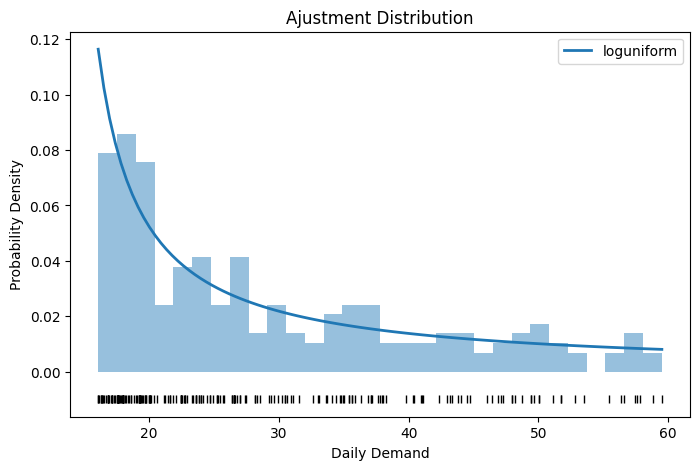

------ MONTH 9 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 3.3546846354699396, 'b': 47.64315565057815, 'loc': 12.64531536267846, 'scale': 1}
Log likelihood: -941.751762667107
AIC:            1891.503525334214
BIC:            1905.9120006177327


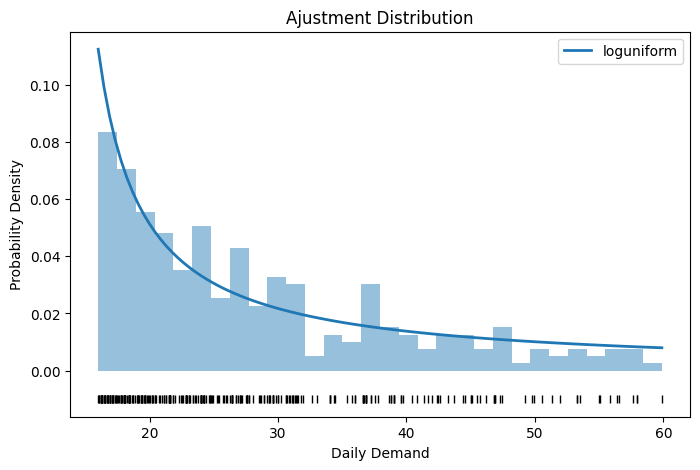

------ MONTH 10 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 19.036164619127007, 'b': 62.436192687504686, 'loc': -3.0361681656041726, 'scale': 1}
Log likelihood: -1071.1780280495257
AIC:            2150.3560560990513
BIC:            2165.144430045073


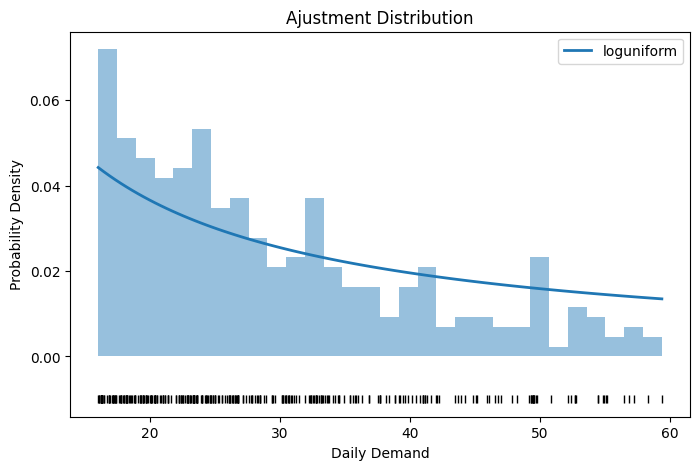

------ MONTH 11 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 3.6095330200602076, 'b': 47.15172579029003, 'loc': 12.390466979856416, 'scale': 1}
Log likelihood: -1013.2505272730886
AIC:            2034.501054546177
BIC:            2049.235373615532


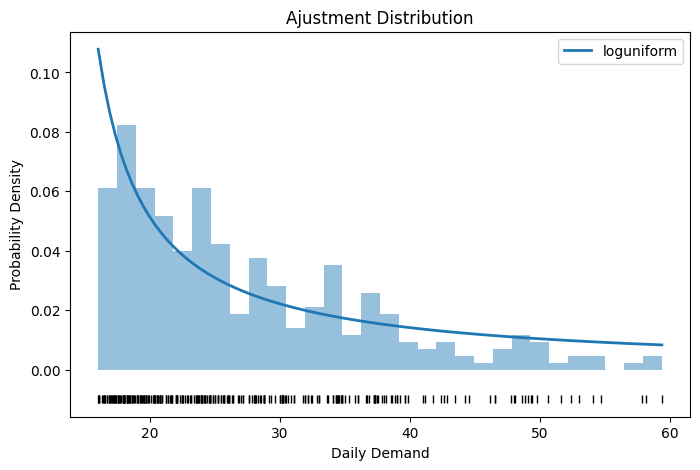

------ MONTH 12 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   loguniform
Dominio:        [-inf, inf]
Parámetros:     {'a': 3.7659030752475173, 'b': 49.68754327198177, 'loc': 12.234096924670936, 'scale': 1}
Log likelihood: -1229.2875965559247
AIC:            2466.5751931118493
BIC:            2481.995480800659


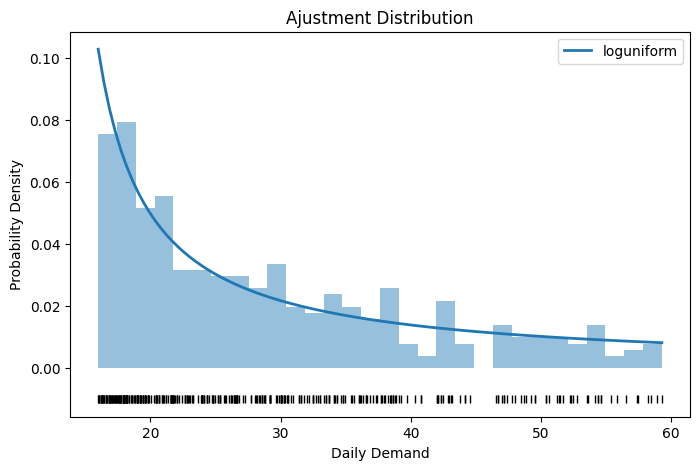

In [21]:
for month in range(1,13):
    data = raw_medium.loc[raw_medium.month == month, 'demand']
    print(f"------ MONTH {month} -------")
    fig, ax = plt.subplots(figsize=(8,5))
    plot_distribution(
        x=data.to_numpy(),
        nombre_distribucion=resultados_medium['distribucion'][1],
        ax=ax
    )
    plt.show()

#### Sampling Layer Medium and Month 1

INFO:__main__:Params: (-5.729147042864096, 1.0241433343194126, 15.008870604804322, 0.0688936493433665)


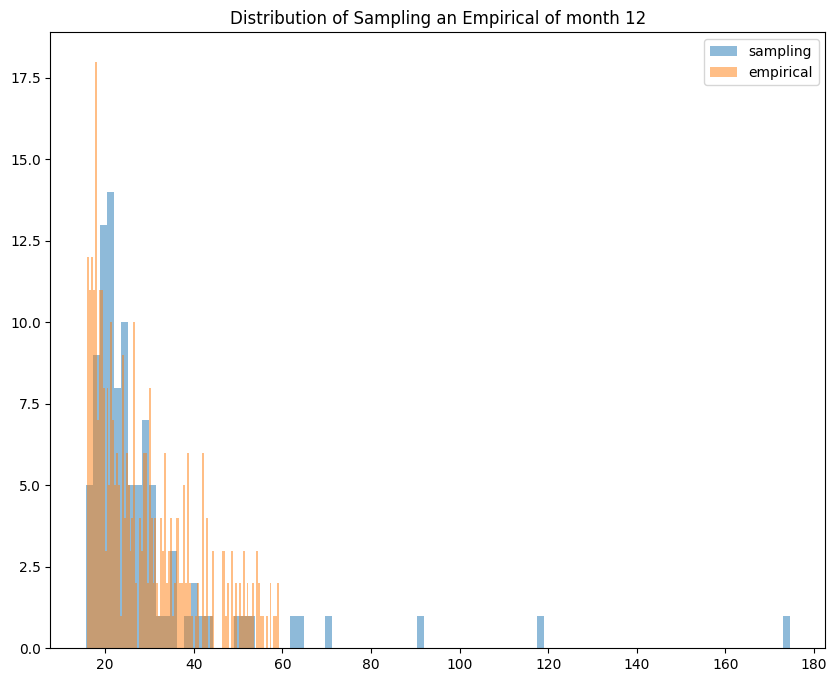

INFO:__main__:Rows 349


In [22]:
MONTH=12
## Distribution Selected
distribution = stats.johnsonsu

# fitting
parametros   = distribution.fit(raw_medium.loc[raw_medium.month == MONTH, 'demand'].to_numpy())
logger.info(f"Params: {parametros}")

# plot with sampling records
fig, axes = plt.subplots(figsize=(10,8))
plt.hist(distribution.rvs(*parametros, size=100), bins = 100, alpha=0.5, label="sampling")
plt.hist(raw_medium.loc[raw_medium.month == MONTH, 'demand'], bins=100, alpha=0.5, label="empirical")
plt.legend()
plt.title(f"Distribution of Sampling an Empirical of month {MONTH}")
plt.show()
logger.info(f"Rows {len(raw_medium.loc[raw_medium.month == MONTH, 'demand'])}")

### 3) Layer High-Demand

In [23]:
raw_high = raw[raw.layer==1].reset_index(drop=1)
logger.info(f"Quantity of rows is {len(raw_high.index)}")

INFO:__main__:Quantity of rows is 507


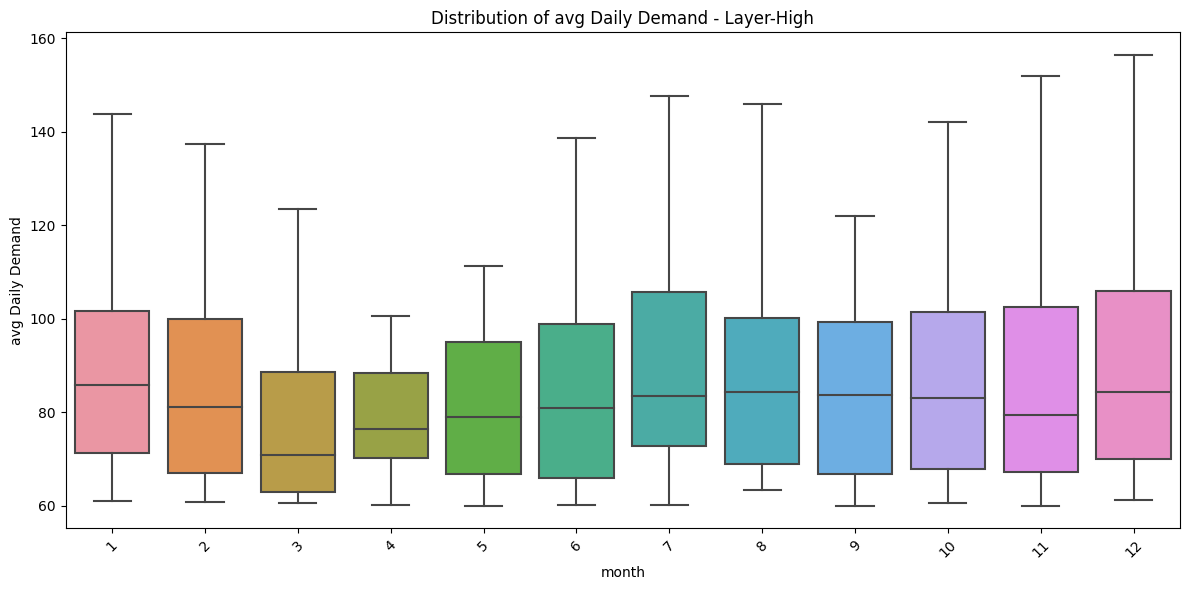

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='demand', data=raw_high, showfliers=False)
plt.xticks(rotation=45)
plt.ylabel('avg Daily Demand')
plt.title('Distribution of avg Daily Demand - Layer-High')
plt.tight_layout()
plt.show()

#### Distribution adjustment

In [25]:
data_to_adjustment = raw_high.loc[raw_high.month == 12, 'demand']

In [26]:
resultados_high = comparison_distribution(
                x=data_to_adjustment.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_high

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,kappa4,-359.624900,727.249799,736.777906,4,"{'h': 1.3098728305000003, 'k': 0.3442996241117..."
1,pearson3,-362.956350,731.912701,739.058781,3,"{'skew': 2.039708134523117, 'loc': 93.70003385..."
2,laplace_asymmetric,-364.084539,734.169077,741.315157,3,"{'kappa': 8.287457927900815e-05, 'loc': 61.199..."
3,exponnorm,-364.394420,734.788840,741.934920,3,"{'K': 518.7743364413642, 'loc': 61.11884819046..."
4,truncnorm,-364.106451,736.212902,745.741009,4,"{'a': 61.19996827935132, 'b': 223.352293707909..."
5,genhyperbolic,-364.444233,738.888466,750.798599,5,"{'p': 1.0450922020187394, 'a': 0.8680789189408..."
6,norminvgauss,-366.260668,740.521337,750.049443,4,"{'a': 70.05386342231725, 'b': 70.0492749327813..."
7,johnsonsu,-366.679273,741.358546,750.886653,4,"{'a': -5.469441823368669, 'b': 0.9384359147251..."
8,truncweibull_min,-367.504309,745.008618,756.918751,5,"{'c': 0.5612422237782936, 'a': 0.0015051912856..."
9,genextreme,-369.588530,745.177060,752.323140,3,"{'c': -0.6091415717522441, 'loc': 75.315581461..."


------ MONTH 1 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -1.9668574542428776, 'b': 1.0289345218169184, 'loc': 63.80970508697986, 'scale': 5.67435615174954}
Log likelihood: -146.48684765569178
AIC:            300.97369531138355
BIC:            306.9597255572495


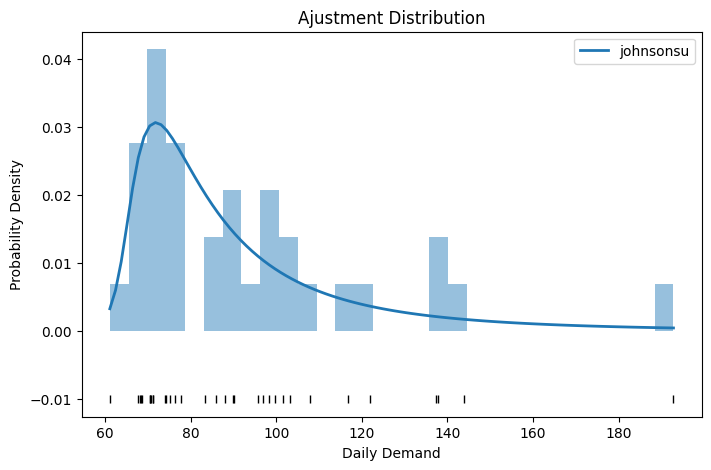

------ MONTH 2 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.6406481672727224, 'b': 0.9503023552851511, 'loc': 58.35135532844109, 'scale': 0.09935751324910724}
Log likelihood: -140.92604779767777
AIC:            289.85209559535554
BIC:            295.7150392065544


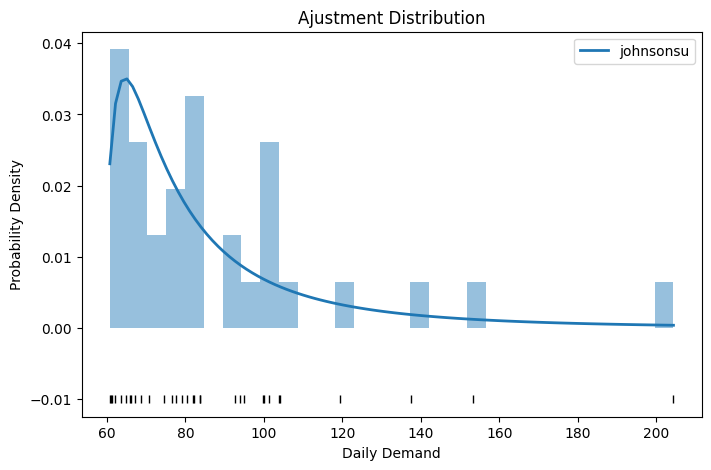

------ MONTH 3 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -4.741177423126032, 'b': 0.6714027069102457, 'loc': 60.31554380270673, 'scale': 0.014370080292324484}
Log likelihood: -78.85699950469913
AIC:            165.71399900939826
BIC:            169.69692810361423


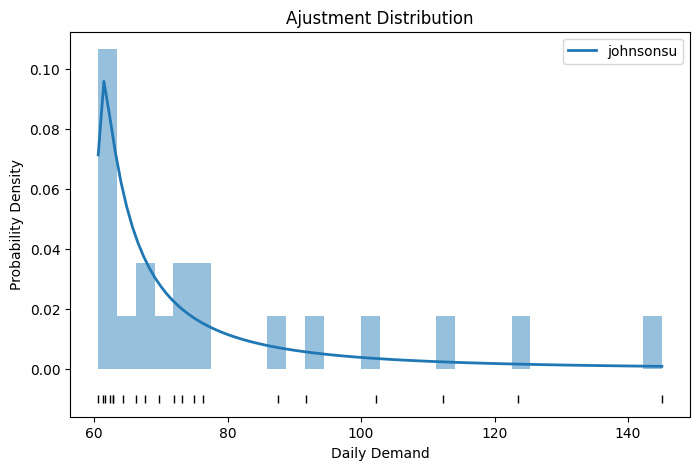

------ MONTH 4 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.829564690087494, 'b': 1.0447419510406966, 'loc': 57.633819581316544, 'scale': 0.14352192491615245}
Log likelihood: -103.72589941235074
AIC:            215.45179882470148
BIC:            220.16401414609328


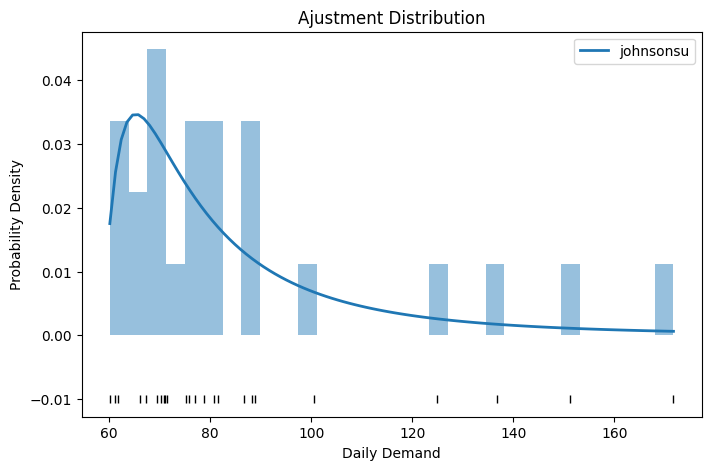

------ MONTH 5 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.919120108469958, 'b': 1.1408880796507899, 'loc': 57.68430940660082, 'scale': 0.22523216407123436}
Log likelihood: -167.36582649229132
AIC:            342.73165298458264
BIC:            349.38589956910124


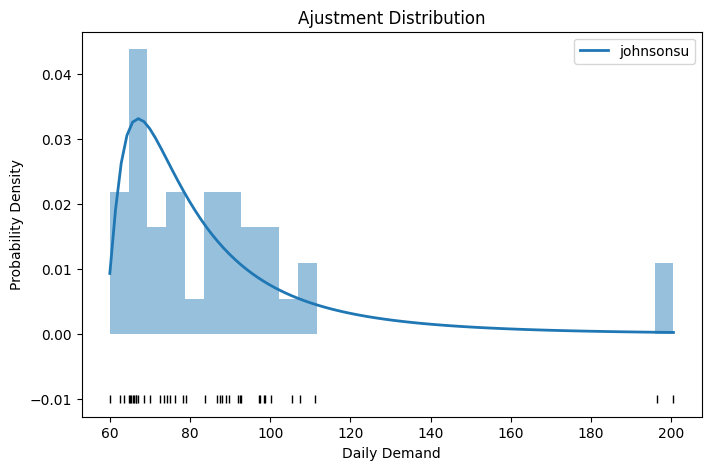

------ MONTH 6 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.1814236404906335, 'b': 0.8554716960125182, 'loc': 58.656425080331076, 'scale': 0.08174403537699348}
Log likelihood: -155.2562586033347
AIC:            318.5125172066694
BIC:            324.733909452627


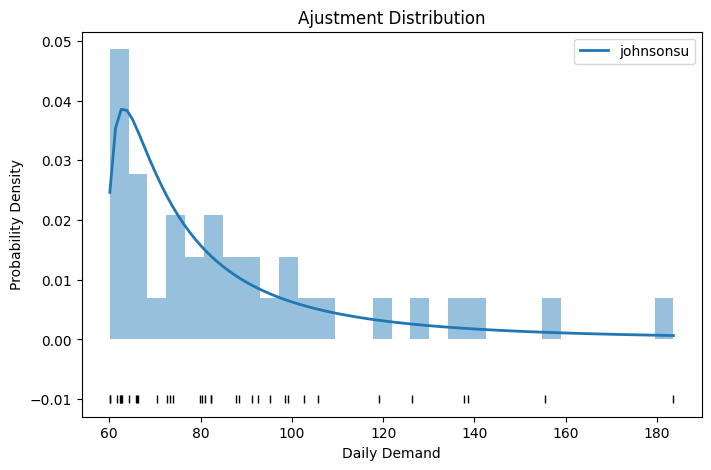

------ MONTH 7 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.745546661887266, 'b': 1.1443043819256786, 'loc': 57.05734474658655, 'scale': 0.33592656581635105}
Log likelihood: -226.07341762203308
AIC:            460.14683524406615
BIC:            467.7949272657787


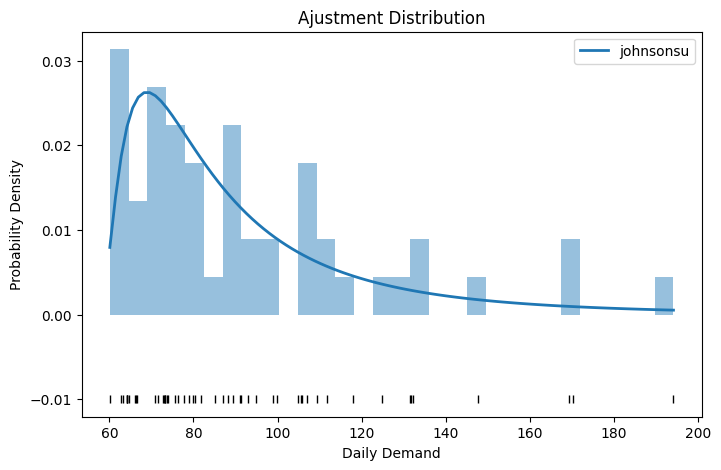

------ MONTH 8 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.430516941552382, 'b': 0.8658882757809272, 'loc': 61.9870272469695, 'scale': 0.06032004849585545}
Log likelihood: -173.33447281373458
AIC:            354.66894562746916
BIC:            361.4244634439249


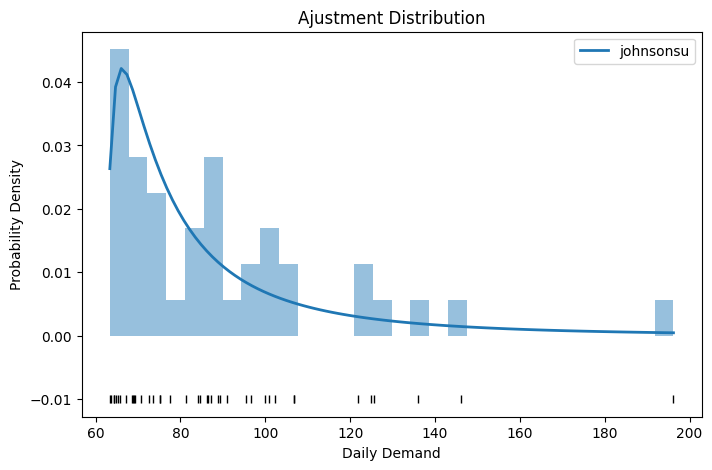

------ MONTH 9 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -6.264683925116836, 'b': 1.230092460423234, 'loc': 54.98532344481824, 'scale': 0.30733497163793133}
Log likelihood: -177.32782098578542
AIC:            362.65564197157084
BIC:            369.41115978802657


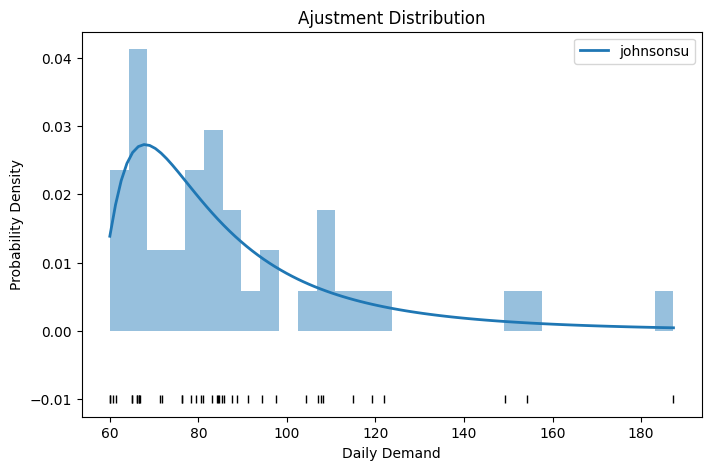

------ MONTH 10 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -6.036291222496305, 'b': 1.0086747089221835, 'loc': 57.77361661356906, 'scale': 0.10259936871248657}
Log likelihood: -234.56237223747365
AIC:            477.1247444749473
BIC:            485.0059121291558


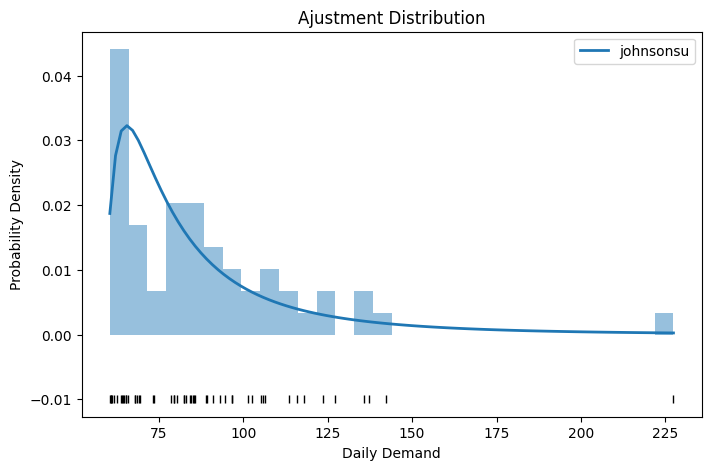

------ MONTH 11 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.300090706369021, 'b': 0.8164430546588242, 'loc': 58.96441767458225, 'scale': 0.05888333475313784}
Log likelihood: -279.92838219156795
AIC:            567.8567643831359
BIC:            576.3002598398291


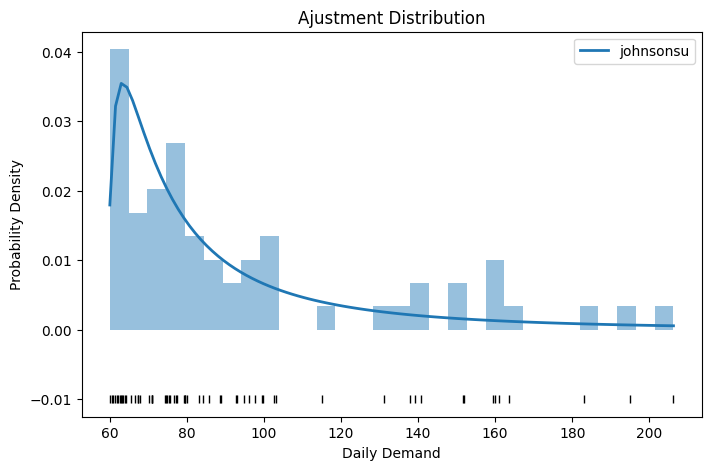

------ MONTH 12 -------
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.469441823368669, 'b': 0.938435914725193, 'loc': 59.55725275732675, 'scale': 0.13054824367854267}
Log likelihood: -366.679273004902
AIC:            741.358546009804
BIC:            750.8866525484995


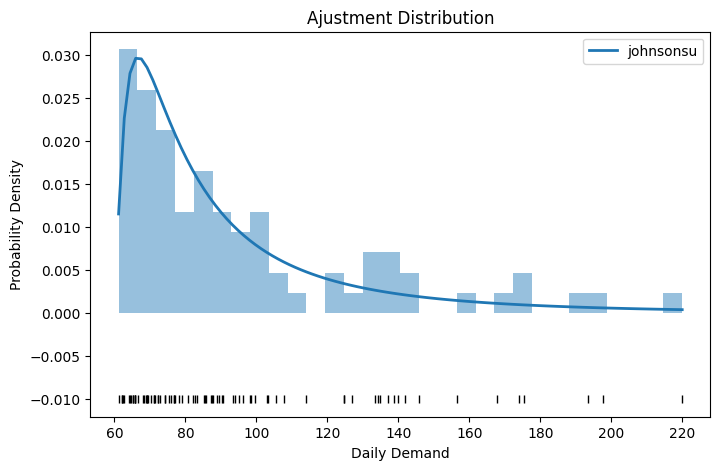

In [27]:
for month in range(1,13):
    data = raw_high.loc[raw_high.month == month, 'demand']
    print(f"------ MONTH {month} -------")
    fig, ax = plt.subplots(figsize=(8,5))
    plot_distribution(
        x=data.to_numpy(),
        nombre_distribucion=resultados_high['distribucion'][7],
        ax=ax
    )
    plt.show()

#### Sampling Layer High and Month 12

INFO:__main__:Params: (-5.1814236404906335, 0.8554716960125182, 58.656425080331076, 0.08174403537699348)


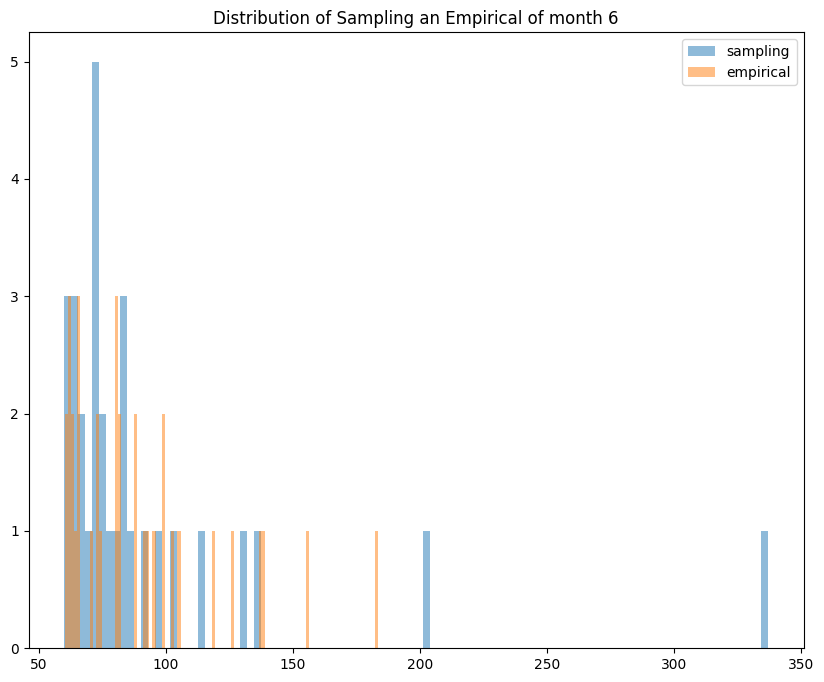

INFO:__main__:Rows 35


In [28]:
MONTH=6
## Distribution Selected
distribution = stats.johnsonsu

# fitting
parametros   = distribution.fit(raw_high.loc[raw_high.month == MONTH, 'demand'].to_numpy())
logger.info(f"Params: {parametros}")

# plot with sampling records
fig, axes = plt.subplots(figsize=(10,8))
plt.hist(distribution.rvs(*parametros, size=30), bins = 100, alpha=0.5, label="sampling")
plt.hist(raw_high.loc[raw_high.month == MONTH, 'demand'], bins=100, alpha=0.5, label="empirical")
plt.legend()
plt.title(f"Distribution of Sampling an Empirical of month {MONTH}")
plt.show()
logger.info(f"Rows {len(raw_high.loc[raw_high.month == MONTH, 'demand'])}")

# Resumen

It is proposed to use the **johnsonsu** distribution to represent the average daily demand for a specific month.
Each **johnsonsu** distribution will be fitted with data from a particular layer and month.

## Considerations

The demand can be sampled at the layer and period level, but in order to calculate the demand for a specific pixel, the empirical mean of the pixel will be used as a weighting to lower or raise the sampled value according to the pixel.

# Generate Params of Distribution avg Daily Demand

In [29]:
def get_params(data: pd.DataFrame, name_distribution: str) -> dict[str, float]:
    """
    Get params of distribution, according to data
    """
    distribucion = getattr(stats, name_distribution)
    parametros = distribucion.fit(data=data)
    
    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))
    return parametros_dict

In [30]:
NAME_DISTRIBUTION = 'johnsonsu'
LAYERS = {
    "low": raw_low,
    "medium": raw_medium,
    "high": raw_high,
}
PERIODS = [i for i in range(1,13)]

In [32]:
output = {}
for layer, df in LAYERS.items():
    logger.info(f"getting params for layer {layer}")
    output[layer] = {}
    for period in PERIODS:
        logger.info(f"running period {period}")
        data = df.loc[df.month == period, 'demand'].to_numpy()
        params = get_params(data, NAME_DISTRIBUTION)
        output[layer][period] = params
        logger.info(params)

INFO:__main__:getting params for layer low
INFO:__main__:running period 1
INFO:__main__:{'a': -4.807745279338757, 'b': 0.773388884111248, 'loc': 0.9927181072134932, 'scale': 0.003381593167730684}
INFO:__main__:running period 2
INFO:__main__:{'a': -4.816430790641132, 'b': 0.7797548561312492, 'loc': 0.99437811936145, 'scale': 0.0036337374577629688}
INFO:__main__:running period 3
INFO:__main__:{'a': -4.947549766877758, 'b': 0.7777076520263277, 'loc': 0.9911220946881644, 'scale': 0.003033144998833001}
INFO:__main__:running period 4
INFO:__main__:{'a': -4.919360522179474, 'b': 0.7740023485024676, 'loc': 0.9909736001278993, 'scale': 0.0030391021166006225}
INFO:__main__:running period 5
INFO:__main__:{'a': -4.126886682947598, 'b': 0.7850403991916988, 'loc': 0.9882063380291453, 'scale': 0.00926217123085547}
INFO:__main__:running period 6
INFO:__main__:{'a': -4.890860326168944, 'b': 0.7825434846293198, 'loc': 0.9848989893866555, 'scale': 0.0037570725613611314}
INFO:__main__:running period 7
INF

In [33]:
import json 
output_json = json.dumps(output, indent=2)

In [ ]:
with open("../../data/scenario-generation/distribution_params.json", "w") as outfile:
    outfile.write(output_json)

In [34]:
print(output_json)

{
  "low": {
    "1": {
      "a": -4.807745279338757,
      "b": 0.773388884111248,
      "loc": 0.9927181072134932,
      "scale": 0.003381593167730684
    },
    "2": {
      "a": -4.816430790641132,
      "b": 0.7797548561312492,
      "loc": 0.99437811936145,
      "scale": 0.0036337374577629688
    },
    "3": {
      "a": -4.947549766877758,
      "b": 0.7777076520263277,
      "loc": 0.9911220946881644,
      "scale": 0.003033144998833001
    },
    "4": {
      "a": -4.919360522179474,
      "b": 0.7740023485024676,
      "loc": 0.9909736001278993,
      "scale": 0.0030391021166006225
    },
    "5": {
      "a": -4.126886682947598,
      "b": 0.7850403991916988,
      "loc": 0.9882063380291453,
      "scale": 0.00926217123085547
    },
    "6": {
      "a": -4.890860326168944,
      "b": 0.7825434846293198,
      "loc": 0.9848989893866555,
      "scale": 0.0037570725613611314
    },
    "7": {
      "a": -5.081622394812156,
      "b": 0.787335957455368,
      "loc": 0.9840140